All resources are listed at the bottom of the page.

In [1]:
# Get important libraries for this class.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
import sys
import logging
#-----------------------------------------------------------
from tensorflow.python.ops import control_flow_ops
from IPython.display import clear_output
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from scipy.cluster.vq import kmeans, vq
from sklearn.metrics import normalized_mutual_info_score
from math import sqrt
#------------------------------------------------------------
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from optparse import OptionParser
from tqdm import tqdm

In [2]:
def standardization(X):
    return normalize(X, axis=0)

In [3]:
def laplacian(A):
    S = np.sum(A, 0)
    D = np.diag(S)
    D = LA.matrix_power(D, -1)
    L = np.dot(D, A)
    return L

In [4]:
def normalization(V):
    return (V - min(V)) / (max(V) - min(V))

In [5]:
class Correlation_Similarity:
    def get_matrix(self, Data):
        X = standardization(Data)
        X = pdist(X, 'correlation')
        X = squareform(X)
        L = laplacian(X)
        Y = np.apply_along_axis(normalization, 1, L)
        return Y

In [6]:
class Cosine_Similarity:
    def get_matrix(self, Data):
        X = standardization(Data)
        X = pdist(X, 'cosine')
        X = squareform(X)
        L = laplacian(X)
        Y = np.apply_along_axis(normalization, 1, L)
        return Y

In [7]:
class Similarity_Dataset_Iterator():
    def __init__(self, data, labels, similarity):
        self.data = data
        self.labels = labels
        self.matrix = similarity.get_matrix(data)
        self.data_size = self.matrix.shape[0]
        self.current_index = 0
    def next_batch(self, num):
        data=self.matrix.transpose()
        labels=self.labels
        idx = np.arange(0 , len(data))
        np.random.shuffle(idx)
        idx = idx[:num]
        data_shuffle = [data[ i] for i in idx]
        labels_shuffle = [labels[ i] for i in idx]
        return data_shuffle, labels_shuffle
    def whole_dataset(self):
        return (self.matrix.transpose(), self.labels)

In [8]:
#  Using Scikit-Learn libraries to fetching the Newsgroups data set: http://scikit-learn.org
def read_NewsGroup_data(similarity):    
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s %(message)s')
    op = OptionParser()
    op.add_option("--lsa", dest="n_components", type="int",
                  help="Preprocess documents with latent semantic analysis.")    
    op.add_option("--no-idf",action="store_false", dest="use_idf", default=True,
                  help="Disable Inverse Document Frequency feature weighting.")
    op.add_option("--use-hashing", action="store_true", default=False,
                  help="Use a hashing feature vectorizer")
    op.add_option("--n-features", type=int, default=10000,
                  help="Maximum number of features to extract from text.")    
    def is_interactive():
        return not hasattr(sys.modules['__main__'], '__file__')
    argv = [] if is_interactive() else sys.argv[1:]
    (opts, args) = op.parse_args(argv)
    if len(args) > 0:
        op.error("this script takes no arguments.")
        sys.exit(1)
    categories_3NG = ['comp.graphics', 'rec.sport.baseball', 'talk.politics.guns']
    # categories = categories_3NG
    dataset = fetch_20newsgroups(subset='train', categories=categories_3NG,
                                 shuffle=True, random_state=42)
    labels = dataset.target[:600]
    true_k = np.unique(labels).shape[0]
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,min_df=2,
                                 stop_words='english',use_idf=opts.use_idf)
    X = vectorizer.fit_transform(dataset.data[:600])
    if opts.n_components:
        svd = TruncatedSVD(opts.n_components)
        normalizer = Normalizer(copy=False)
        lsa = make_pipeline(svd, normalizer)
        X = lsa.fit_transform(X)
        explained_variance = svd.explained_variance_ratio_.sum()
    return Similarity_Dataset_Iterator(X.toarray(), labels, similarity)

In [9]:
# Call Correlation_Similarity as similarity dataset.
trainSet_correlation = read_NewsGroup_data(Correlation_Similarity())

In [10]:
# Call Cosine_Similarity as similarity dataset.
trainSet_cosine = read_NewsGroup_data(Cosine_Similarity())

In [11]:
n_input = trainSet_correlation.data_size #--------- Number of input data.
# Define the number of hidden layer. 
if n_input >= 1024:
    Nn = int(2048)
elif n_input >= 512:
    Nn = int(1024)
elif n_input >= 256:
    Nn = int(512)

In [12]:
n_hidden_1 = int(Nn/2) #-------------------- The autoencoder hidden layer 1.
n_code = str(int(n_hidden_1/2)) #----------- The number of output dimension value.

In [13]:
print('Layer 1: -----------', n_input)
print('Layer 2: -----------', n_hidden_1)
print('Layer 3: -----------', int(n_code))

Layer 1: ----------- 600
Layer 2: ----------- 512
Layer 3: ----------- 256


In [14]:
def k_means_(X, n_clusters):
    kmeans_centroids,_ =  kmeans(X, n_clusters)
    kmeans_, _ = vq(X, kmeans_centroids)
    return kmeans_

In [15]:
def encoder(x, n_code, mode_train):    
    with tf.variable_scope("encoder"):        
        with tf.variable_scope("hidden-layer-1"):
            hidden_1 = layer(x, [n_input, n_hidden_1], [n_hidden_1], mode_train)
        with tf.variable_scope("embedded"):
            code = layer(hidden_1, [n_hidden_1, n_code], [n_code], mode_train)
    return code

In [16]:
def decoder(code, n_code, mode_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden-layer-1"):
            hidden_1 = layer(code, [n_code, n_hidden_1], [n_hidden_1], mode_train)
        with tf.variable_scope("reconstructed"):
            output = layer(hidden_1, [n_hidden_1, n_input], [n_input], mode_train)
    return output

In [17]:
def batch_norm(x, n_out, mode_train):
    beta_initialize = tf.constant_initializer(value=0.1, dtype=tf.float32)
    gamma_initialize = tf.constant_initializer(value=0.1, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_initialize)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_initialize)
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(mode_train, mean_var, lambda: (ema_mean, ema_var))
    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-08, True)
    return tf.reshape(normed, [-1, n_out])

In [18]:
def layer(input, weight_shape, bias_shape, mode_train):
    value_initialize = (1.0 / weight_shape[0] ** 0.5)
    weight_initialize = tf.random_normal_initializer(stddev = value_initialize, seed = None)
    bias_initialize = tf.constant_initializer(value=0.0, dtype=tf.float32)
    w = tf.get_variable("w", weight_shape, initializer=weight_initialize)
    b = tf.get_variable("b", bias_shape, initializer=bias_initialize)
    return tf.nn.sigmoid(batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train))

In [19]:
def loss(reconstructed, x):
    with tf.variable_scope("train"):
        train_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(reconstructed, x)), 1))
        return train_loss

In [20]:
def training(cost, learning_rate, beta1, beta2, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon=1e-08, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [21]:
# Parameters
n_layers = 3 #------------------------------ Number of Neural Networks Layers.
beta1 = 0.9 #------------------------------- The decay rate 1.  
beta2 = 0.999 #----------------------------- The decay rate 2.
learning_rate = (beta1/n_input) #----------- The learning rate.
n_batch = math.ceil(sqrt(sqrt(n_input))) #-- Number of selection data in per step.
n_backpro = math.ceil(n_input/n_batch) #---- Number of Backpro in per epoch.
n_clusters = 3 #---------------------------- Number of clusters.

In [22]:
data_cor, labels_cor = trainSet_correlation.whole_dataset() #-- Allocation of data and labels
data_cos, labels_cos = trainSet_cosine.whole_dataset() #------- Allocation of data and labels

In [23]:
results_cor=[] #--------------------------- A list to keep all NMI scores.
loss_cost_cor=[] #------------------------- A list to keep all training evaluations.
seeding_cor=[] #--------------------------- A list to keep all steps.

In [24]:
for i in range(1, 11):
    with tf.Graph().as_default():    
        with tf.variable_scope("autoencoder_architecture"):
            x = tf.placeholder("float", [None, n_input])   
            mode_train = tf.placeholder(tf.bool)
            code = encoder(x, int(n_code), mode_train)
            reconstructed = decoder(code, int(n_code), mode_train)
            cost = loss(reconstructed, x)
            global_step = tf.Variable(0, name='global_step', trainable=False)
            train_optimizer = training(cost, learning_rate, beta1, beta2, global_step)
            sess = tf.Session()
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
            # Training cycle
            for ii in range(n_layers):
                # Fit training with backpropagation using batch data.
                for jj in range(n_backpro):
                    miniData, _ = trainSet_correlation.next_batch(n_batch)
                    _, new_cost = sess.run([train_optimizer,cost], feed_dict={x: miniData,
                                                                              mode_train: True})       
                #------------------------- End of the Optimization ------------------------------
                
    # Getting embedded codes and running K-Means on them.
    ae_codes_cor = sess.run(code, feed_dict={x: data_cor, mode_train: False})        
    idx_cor = k_means_(ae_codes_cor, n_clusters)
    ae_nmi_cor = normalized_mutual_info_score(labels_cor, idx_cor)
    ae_nmi_cor = ae_nmi_cor*100
    results_cor.append(ae_nmi_cor)    
    seeding_cor.append(i)
    loss_cost_cor.append(new_cost)    
    print("NMI score for AE is: {:0.2f} and new cost is: {:0.2f} in {:d} step of seeding."
          .format(ae_nmi_cor, new_cost, i))

NMI score for AE is: 81.14 and new cost is: 70.36 in 1 step of seeding.
NMI score for AE is: 85.60 and new cost is: 70.65 in 2 step of seeding.
NMI score for AE is: 81.72 and new cost is: 70.64 in 3 step of seeding.
NMI score for AE is: 83.27 and new cost is: 70.40 in 4 step of seeding.
NMI score for AE is: 83.73 and new cost is: 70.23 in 5 step of seeding.
NMI score for AE is: 84.69 and new cost is: 70.49 in 6 step of seeding.
NMI score for AE is: 84.04 and new cost is: 70.84 in 7 step of seeding.
NMI score for AE is: 83.32 and new cost is: 70.96 in 8 step of seeding.
NMI score for AE is: 82.44 and new cost is: 70.16 in 9 step of seeding.
NMI score for AE is: 83.71 and new cost is: 70.80 in 10 step of seeding.


In [25]:
print("The Average of NMI Score for >>> {:d} <<< Random Factors in Autoencoder Correlation is >>> {:0.2f} <<<"
      .format(len(seeding_cor), (np.mean(results_cor))))

The Average of NMI Score for >>> 10 <<< Random Factors in Autoencoder Correlation is >>> 83.37 <<<


In [26]:
results_cor

[81.141579366316279,
 85.597559650628142,
 81.72329841690204,
 83.27027416571859,
 83.725137221212137,
 84.692385276772825,
 84.041285866078738,
 83.324720546567903,
 82.441775144916434,
 83.713348790719621]

In [27]:
results_cos=[] #--------------------------- A list to keep all NMI scores.
loss_cost_cos=[] #------------------------- A list to keep all training evaluations.
seeding_cos=[] #--------------------------- A list to keep all steps.

In [28]:
for i in range(1, 11):
    with tf.Graph().as_default():    
        with tf.variable_scope("autoencoder_architecture"):
            x = tf.placeholder("float", [None, n_input])   
            mode_train = tf.placeholder(tf.bool)
            code = encoder(x, int(n_code), mode_train)
            reconstructed = decoder(code, int(n_code), mode_train)
            cost = loss(reconstructed, x)
            global_step = tf.Variable(0, name='global_step', trainable=False)
            train_optimizer = training(cost, learning_rate, beta1, beta2, global_step)
            sess = tf.Session()
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
            # Training cycle
            for ii in range(n_layers):
                # Fit training with backpropagation using batch data.
                for jj in range(n_backpro):
                    miniData, _ = trainSet_cosine.next_batch(n_batch)
                    _, new_cost = sess.run([train_optimizer,cost], feed_dict={x: miniData,
                                                                              mode_train: True})       
                #------------------------- End of the Optimization ------------------------------

    # Getting embedded codes and running K-Means on them.
    ae_codes_cos = sess.run(code, feed_dict={x: data_cos, mode_train: False})        
    idx_cos = k_means_(ae_codes_cos, n_clusters)
    ae_nmi_cos = normalized_mutual_info_score(labels_cos, idx_cos)
    ae_nmi_cos = ae_nmi_cos*100
    results_cos.append(ae_nmi_cos)    
    seeding_cos.append(i)
    loss_cost_cos.append(new_cost)    
    print("NMI score for AE is: {:0.2f} and new cost is: {:0.2f} in {:d} step of seeding."
          .format(ae_nmi_cos, new_cost, i))

NMI score for AE is: 77.01 and new cost is: 73.19 in 1 step of seeding.
NMI score for AE is: 76.50 and new cost is: 72.76 in 2 step of seeding.
NMI score for AE is: 79.67 and new cost is: 73.69 in 3 step of seeding.
NMI score for AE is: 77.75 and new cost is: 73.43 in 4 step of seeding.
NMI score for AE is: 76.01 and new cost is: 73.32 in 5 step of seeding.
NMI score for AE is: 76.30 and new cost is: 73.46 in 6 step of seeding.
NMI score for AE is: 76.33 and new cost is: 72.77 in 7 step of seeding.
NMI score for AE is: 78.91 and new cost is: 73.46 in 8 step of seeding.
NMI score for AE is: 76.76 and new cost is: 72.95 in 9 step of seeding.
NMI score for AE is: 77.82 and new cost is: 73.48 in 10 step of seeding.


In [29]:
print("The Average of NMI Score for >>> {:d} <<< Random Factors in Autoencoder Cosine is >>> {:0.2f} <<<"
      .format(len(seeding_cos), (np.mean(results_cos))))

The Average of NMI Score for >>> 10 <<< Random Factors in Autoencoder Cosine is >>> 77.31 <<<


In [30]:
results_cos

[77.007590066411282,
 76.504352549867065,
 79.668435637511664,
 77.750027835788387,
 76.012372141698464,
 76.298278587623102,
 76.333008295098523,
 78.908850902829471,
 76.756575375770851,
 77.821649441779954]

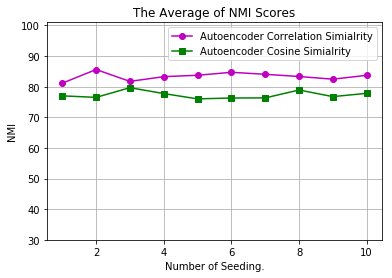

In [31]:
warnings.filterwarnings('ignore')
plt.ylim(30,101)
plt.plot(seeding_cor, results_cor, label='Autoencoder Correlation Simialrity', color='m', marker='o')
plt.plot(seeding_cos, results_cos, label='Autoencoder Cosine Simialrity', color='g', marker='s')
plt.xlabel('Number of Seeding.')
plt.ylabel('NMI')
plt.grid()
plt.title('The Average of NMI Scores')
plt.legend(loc='best')
plt.show()

In [32]:
print("Autoencoder Clustering on Cosine: ------------ {:0.2f}".format(np.mean(results_cos)))
print("Autoencoder Clustering on Correlation: ------- {:0.2f}".format(np.mean(results_cor)))

Autoencoder Clustering on Cosine: ------------ 77.31
Autoencoder Clustering on Correlation: ------- 83.37


____________________________________________________________________________________________________________________________


____________________________________________________________________________________________________________________________

Refrences:

SciPy (the library) Jones E, Oliphant E, Peterson P, et al. SciPy: Open Source Scientific Tools for Python, 2001-, http://www.scipy.org/ [Online; accessed 2018-02-20]. Here’s an example of a BibTeX entry:

@Misc{, author = {Eric Jones and Travis Oliphant and Pearu Peterson and others}, title = {{SciPy}: Open source scientific tools for {Python}}, year = {2001--}, url = "http://www.scipy.org/", note = {[Online; accessed

NumPy & SciPy:

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37 (publisher link)

IPython:

Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53 (publisher link)

Matplotlib:

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55 (publisher link)

Scikit-learn:

Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-2830 (2011) (publisher link)

TensorFlow:

@misc{tensorflow2015-whitepaper, title={ {TensorFlow}: Large-Scale Machine Learning on Heterogeneous Systems}, url={https://www.tensorflow.org/}, note={Software available from tensorflow.org},

Jupyter Notebooks:

@conference{Kluyver:2016aa, Author = {Thomas Kluyver and Benjamin Ragan-Kelley and Fernando P{\'e}rez and Brian Granger and Matthias Bussonnier and Jonathan Frederic and Kyle Kelley and Jessica Hamrick and Jason Grout and Sylvain Corlay and Paul Ivanov and Dami{\'a}n Avila and Safia Abdalla and Carol Willing}, Booktitle = {Positioning and Power in Academic Publishing: Players, Agents and Agendas}, Editor = {F. Loizides and B. Schmidt}, Organization = {IOS Press}, Pages = {87 - 90}, Title = {Jupyter Notebooks -- a publishing format for reproducible computational workflows}, Year = {2016}}